EDAreport.html 파일을 먼저 확인해주시기 바랍니다.
해당 파일은 R의 summarytools library를 이용해 작성한 train.csv파일의 데이터 탐색 결과이며, 이를 통해 다음과 같은 사실을 알 수 있습니다.
1. integer features들의 치우친 분포(skewed distribution), 변수별 중위값 및 NA값의 비율
2. catogorical features는 변수 당 최대 37774개의 항목이 있음
3. 전체 2536535 레코드 중 137개가 중복됨
4. 77.8%의 레코드가 0으로 라벨링 되었으며, 나머지 22.2%가 1 (sufficiently balanced)

추가적으로, train, validation, test datasets의 Timestamp는 정렬된 상태임

위 내용에 기반해 이 노트북은 추가적인 피쳐 엔지니어링 및 모델링을 수행합니다.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import OneHotEncoder
import scipy
from scipy import sparse
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler

In [53]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
train = pd.read_csv("gdrive/MyDrive/Colab Notebooks/kakaobank_ml/train.csv")
val = pd.read_csv("gdrive/MyDrive/Colab Notebooks/kakaobank_ml/validation.csv")
test = pd.read_csv("gdrive/MyDrive/Colab Notebooks/kakaobank_ml/test.csv")

Data imputation: integer features

모든 정수형 변수들은 0또는 -1에 치우친 분포를 갖으므로, 평균값이 아닌 중위값으로 NaN을 대체.

또한 isNaN 변수를 생성하여 data imputation후에도 모델 훈련시 이를 활용할 수 있도록 함.

In [55]:
def int_features_impute(df):
    for i in range(1,9):
        imputed_variable = 'integer_'+str(i)+'_wasNaN'
        feature_name = 'integer_feature_'+str(i)
        df.assign(imputed_variable = np.where(df[feature_name]!= df[feature_name], 1, 0))
        df[feature_name].fillna((df[feature_name].median()), inplace=True)
    return df

Data imputation: categorical features

범주형 변수의 경우, NaN값을 문자열 'nan'으로 대체. 

추후 validation, test dataset에서 테스트 데이터에 없는 항목이 나올 경우 Out of Vocabulary (OOV)처리 예정

In [56]:
def fillna_unknown(df):
    imputed_df = df.fillna('nan')
    return imputed_df

In [57]:
train_df = int_features_impute(train)
imputed_train = fillna_unknown(train_df)

vali_df = int_features_impute(val)
imputed_vali = fillna_unknown(vali_df)

# test_df = int_features_impute(test)
# test_df.pop('id')
# imputed_test = fillna_unknown(test_df)

Feature normalization

기존의 수치형 피쳐를 정규화(평균 0, 표준편차 1)

메모리 절약을 위해 추가적인 피쳐엔지니어링 전에 수행

In [7]:
numeric_cols = ['click_timestamp', 'integer_feature_1', 'integer_feature_2',
       'integer_feature_3', 'integer_feature_4', 'integer_feature_5',
       'integer_feature_6', 'integer_feature_7', 'integer_feature_8']

In [8]:
scaler = StandardScaler() 
numeric_train = scaler.fit_transform( imputed_train[numeric_cols] ) 
numeric_vali = scaler.transform( imputed_vali[numeric_cols] ) 

In [9]:
imputed_train[numeric_cols] = numeric_train
imputed_vali[numeric_cols] = numeric_vali

In [10]:
imputed_train.head()

,click_timestamp,integer_feature_1,integer_feature_2,integer_feature_3,integer_feature_4,integer_feature_5,integer_feature_6,integer_feature_7,integer_feature_8,categorical_feature_1,categorical_feature_2,categorical_feature_3,categorical_feature_4,categorical_feature_5,categorical_feature_6,categorical_feature_7,categorical_feature_8,categorical_feature_9,label
0,-1.797944,-0.158484,-0.273658,-0.262264,-0.144026,-0.269290,-0.192979,-0.212794,-0.322726,82584581,572ee1a4,414baade,0ab261cb,4ab811c9,nan,f8cbd89d,776ce399,nan,0
1,-1.797940,0.220638,0.668383,1.954428,0.078918,1.815397,-0.391918,-0.187862,-0.077319,4ba15056,9cc5f4bc,1f0cb5c0,c84c9c4e,6b4b1a1d,c82b2a00,9ac3fc32,3486227d,9a2a221f,0
2,-1.797907,-0.158484,-0.273658,-0.262264,-0.144026,-0.269290,0.403839,-0.250288,-0.182493,9a9e5801,bbf70d82,0fb83956,2ff05004,ab2497dc,nan,862dcf90,e5ba7672,nan,0
3,-1.797898,-0.158484,-0.273658,-0.262264,-0.144026,-0.269290,-0.192979,-0.246315,-0.322726,24ad6de8,243a7e36,9dc594c1,aacfa636,b3f7fb1d,nan,3f172b3f,3486227d,nan,1
4,-1.797886,-0.158484,-0.273658,-0.262264,-0.144026,-0.269290,0.204899,-0.250288,-0.094848,4f06a460,5911fc7e,d5b22f0b,cd57c18b,a8840224,nan,8d787bee,e5ba7672,nan,0


Time-series feature generation.

이전과 현재 행들을 포함하여 2,5,10개 행들의 평균/표준편차를 피쳐로 사용

In [11]:
concat_df = pd.concat([imputed_train, imputed_vali],axis=0)

In [12]:
window=2

In [13]:
def past_features_create(df, window=100):
  for i in range(1,9):
    df['avg_int'+str(i)] = df['integer_feature_'+str(i)].rolling(window=window).mean() 
    df['var_int'+str(i)] = df['integer_feature_'+str(i)].rolling(window=window).std() 
    df['avg_int'+str(i)+'_5'] = df['integer_feature_'+str(i)].rolling(window=window*5).mean() 
    df['var_int'+str(i)+'_5'] = df['integer_feature_'+str(i)].rolling(window=window*5).std() 
    df['avg_int'+str(i)+'_10'] = df['integer_feature_'+str(i)].rolling(window=window*10).mean() 
    df['var_int'+str(i)+'_10'] = df['integer_feature_'+str(i)].rolling(window=window*10).std() 
  return df

In [14]:
concat_df_timefeatures = past_features_create(concat_df,  window=window).iloc[10*window-1:,:]

In [15]:
final_train = concat_df_timefeatures.iloc[:-len(val),:]
final_vali = concat_df_timefeatures.iloc[-len(val):,:]
# final_test = concat_df_timefeatures.iloc[-len(test):,:]

In [16]:
final_train.head()

,click_timestamp,integer_feature_1,integer_feature_2,integer_feature_3,integer_feature_4,integer_feature_5,integer_feature_6,integer_feature_7,integer_feature_8,categorical_feature_1,categorical_feature_2,categorical_feature_3,categorical_feature_4,categorical_feature_5,categorical_feature_6,categorical_feature_7,categorical_feature_8,categorical_feature_9,label,avg_int1,var_int1,avg_int1_5,var_int1_5,avg_int1_10,var_int1_10,avg_int2,var_int2,avg_int2_5,var_int2_5,avg_int2_10,var_int2_10,avg_int3,var_int3,avg_int3_5,var_int3_5,avg_int3_10,var_int3_10,avg_int4,var_int4,avg_int4_5,var_int4_5,avg_int4_10,var_int4_10,avg_int5,var_int5,avg_int5_5,var_int5_5,avg_int5_10,var_int5_10,avg_int6,var_int6,avg_int6_5,var_int6_5,avg_int6_10,var_int6_10,avg_int7,var_int7,avg_int7_5,var_int7_5,avg_int7_10,var_int7_10,avg_int8,var_int8,avg_int8_5,var_int8_5,avg_int8_10,var_int8_10
19,-1.797820,-0.158484,-0.273658,-0.262264,-0.144026,-0.26929,-0.391918,-0.175869,-0.235080,ac9c9952,ae46962e,ad3508b1,575579da,93b18cb5,nan,59a58e86,e5ba7672,nan,0,-0.158484,3.725290e-09,-0.120572,0.119889,-0.120572,0.116691,-0.273658,0.000000,-0.179454,0.2979,-0.179454,0.289954,-0.262264,1.435264e-09,-0.14332,0.363647,-0.091958,0.546051,-0.144026,3.725290e-09,-0.077143,0.150476,-0.099437,0.116633,-0.269290,0.000000,-0.160819,0.343017,-0.110820,0.514028,-0.292449,0.140671,0.513255,1.385015,0.209873,1.025868,-0.050620,0.177128,-0.141035,0.126937,-0.162190,0.106953,0.054149,0.409031,0.015585,0.379035,-0.067678,0.298046
20,-1.797820,-0.158484,-0.273658,-0.262264,-0.144026,-0.26929,-0.292449,-0.234889,-0.287667,faca1639,4807da4a,7fde5a70,23c80a6e,e69eaa04,nan,d2df39f3,e5ba7672,nan,0,-0.158484,3.725290e-09,-0.120572,0.119889,-0.120572,0.116691,-0.273658,0.000000,-0.179454,0.2979,-0.179454,0.289954,-0.262264,1.435264e-09,-0.14332,0.363647,-0.091958,0.546051,-0.144026,3.725290e-09,-0.077143,0.150476,-0.099437,0.116633,-0.269290,0.000000,-0.160819,0.343017,-0.110820,0.514028,-0.342184,0.070336,0.503308,1.390995,0.204899,1.028163,-0.205379,0.041734,-0.142185,0.127815,-0.163294,0.107615,-0.261374,0.037185,0.015585,0.379035,-0.065925,0.296567
21,-1.797804,-0.158484,-0.273658,-0.262264,-0.144026,-0.26929,-0.192979,0.022002,-0.217551,d654cd67,04d863d5,7fde5a70,23c80a6e,e69eaa04,nan,fec218c0,e5ba7672,nan,0,-0.158484,3.725290e-09,-0.158484,0.000000,-0.139528,0.084774,-0.273658,0.000000,-0.273658,0.0000,-0.226556,0.210647,-0.262264,1.435264e-09,-0.25866,0.011398,-0.202792,0.257610,-0.144026,3.725290e-09,-0.121732,0.070501,-0.110585,0.109100,-0.269290,0.000000,-0.269290,0.000000,-0.215054,0.242550,-0.242714,0.070336,0.503308,1.390995,0.214846,1.023034,-0.106444,0.181650,-0.126469,0.138029,-0.152801,0.115067,-0.252609,0.049580,-0.010709,0.385798,-0.072937,0.298502
22,-1.797804,-0.158484,-0.273658,-0.262264,-0.144026,-0.26929,0.105430,-0.250061,-0.235080,c13b3446,fffe2a63,ca280131,621dddfe,fc5dea81,nan,06373944,e5ba7672,nan,0,-0.158484,3.725290e-09,-0.158484,0.000000,-0.139528,0.084774,-0.273658,0.000000,-0.273658,0.0000,-0.226556,0.210647,-0.262264,1.435264e-09,-0.25866,0.011398,-0.202792,0.257610,-0.144026,3.725290e-09,-0.121732,0.070501,-0.110585,0.109100,-0.269290,0.000000,-0.269290,0.000000,-0.215054,0.242550,-0.043775,0.211007,0.533149,1.377534,0.199926,1.022309,-0.114029,0.192377,-0.151609,0.135025,-0.152790,0.115057,-0.226316,0.012395,-0.017720,0.389532,-0.075566,0.299747
23,-1.797804,0.220638,0.668383,-0.262264,-0.144026,2.17132,-0.093510,-0.249455,0.203145,4bbb6072,65c9624a,3d80d418,bd3bc740,dd2f45db,0798bd9b,e44b5a03,3486227d,aab7b783,1,0.031077,2.680799e-01,-0.120572,0.119889,-0.120572,0.116691,0.197363,0.666124,-0.179454,0.2979,-0.179454,0.289954,-0.262264,1.435264e-09,-0.25866,0.011398,-0.202792,0.257610,-0.144026,3.725290e-09,-0.121732,0.070501,-0.110585,0.109100,0.951015,1.725772,-0.025229,0.771789,-0.093024,0.585428,0.005960,0.140671,0.543096,1.372056,0.204899,1.020537,-0.249758,0.000428,-0.179050,0.122455,-0.152947,0.115194,-0.015968,0.309872,0.019090,0.391460,-0.049

Tensorflow input data creation

판다스 데이터프레임을 텐서플로 데이터셋으로 변형

In [19]:
def df_to_dataset(dataframe, shuffle=False, batch_size=1000):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [20]:
train_ds = df_to_dataset(final_train)
vali_ds = df_to_dataset(final_vali)
# test_ds = df_to_dataset(final_test)

In [21]:
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [22]:
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [23]:
example_batch = next(iter(train_ds))[0]

In [24]:
numeric_cols2 = ['click_timestamp', 'integer_feature_1', 'integer_feature_2',
       'integer_feature_3', 'integer_feature_4', 'integer_feature_5',
       'integer_feature_6', 'integer_feature_7', 'integer_feature_8','avg_int1', 'var_int1', 'avg_int1_5',
       'var_int1_5', 'avg_int1_10', 'var_int1_10', 'avg_int2', 'var_int2',
       'avg_int2_5', 'var_int2_5', 'avg_int2_10', 'var_int2_10', 'avg_int3',
       'var_int3', 'avg_int3_5', 'var_int3_5', 'avg_int3_10', 'var_int3_10',
       'avg_int4', 'var_int4', 'avg_int4_5', 'var_int4_5', 'avg_int4_10',
       'var_int4_10', 'avg_int5', 'var_int5', 'avg_int5_5', 'var_int5_5',
       'avg_int5_10', 'var_int5_10', 'avg_int6', 'var_int6', 'avg_int6_5',
       'var_int6_5', 'avg_int6_10', 'var_int6_10', 'avg_int7', 'var_int7',
       'avg_int7_5', 'var_int7_5', 'avg_int7_10', 'var_int7_10', 'avg_int8',
       'var_int8', 'avg_int8_5', 'var_int8_5', 'avg_int8_10', 'var_int8_10']

Feature layer creation

첫 레이어에서 카테고리형 피쳐들을 임베딩

In [46]:
feature_columns = []

# 수치형 열
for header in numeric_cols2:
  feature_columns.append(feature_column.numeric_column(header))


# 임베딩 열
for cate_number in range(1,10):
  cate = feature_column.categorical_column_with_vocabulary_list(
        'categorical_feature_'+str(cate_number), np.unique(final_train['categorical_feature_'+str(cate_number)]))
  cate_embedding = feature_column.embedding_column(cate, dimension=100)
  feature_columns.append(cate_embedding)

In [47]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

Modeling

모델링의 핵심적인 이슈는 오버피팅이였으며, 이를 해결하기위해 0.7이상의 dropout과 0.01이상의 regularization 사용

In [48]:
import keras

In [49]:
model = tf.keras.models.Sequential([
  feature_layer,
  # tf.keras.layers.Dropout(0.5),
  # tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-2)),  
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-2)),  
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-1)),  
  tf.keras.layers.Dropout(0.8),  
  layers.Dense(1, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(1e-4))
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=vali_ds,
          epochs=10, 
          batch_size=1000,
          verbose=1, 
          shuffle=True)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2536/2537 [============================>.] - ETA: 0s - loss: 1.1232 - accuracy: 0.7885WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'click_timestamp': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=float64>, 'integer_feature_1': <tf.Tensor 'ExpandDims_34:0' shape=(None, 1) dtype=float64>, 'integer_feature_2': <tf.Tensor 'ExpandDims_35:0' shape=(None, 1) dtype=float64>, 'integer_feature_3': <tf.Tensor 'ExpandDims_36:0' shape=(None, 1) dtype=float64>, 'integer_feature_4': <tf.Tensor 'ExpandDims_37:0' shape=(None, 1) dtype=float64>, 'integer_feature_5': <tf.Tensor 'ExpandDims_38:0' shape=(None, 1) dtype=float64>, 'integer_feature_6': <tf.Tensor 'ExpandDims_39:0' shape=(None, 1) dtype=float64>, 'integer_feature_7': <tf.Tensor 'ExpandDims_40:0' shape=(None, 1) dtype=float64>, 'integer_fe

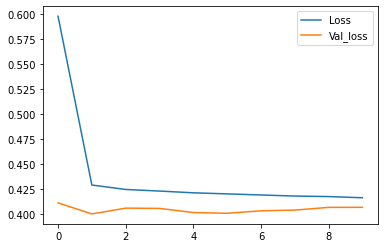

In [50]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'][0:], label='Loss')
plt.plot(history.history['val_loss'][0:], label='Val_loss')
plt.legend()
plt.show()

In [51]:
loss, accuracy = model.evaluate(vali_ds)
print("정확도", accuracy)

494/494 [==============================] - 18s 35ms/step - loss: 0.4069 - accuracy: 0.8359
정확도 0.8358511924743652


* Test dataset prediction을 위한 최종 모델은 train과 validation datasets을 결합하여 모델을 다시 훈련하였으며, 과정은 위와 동일함.

In [ ]:
y_pred = model.predict(x_vali)